## Importing need packages

In [33]:
import pandas as pd
import urllib.request
import pymatgen
from pymatgen.ext.matproj import MPRester
import json
import numpy as np
import matplotlib.pyplot as plt

## Fuctions that help retrive entries from HTEM and Materials Project Databases. The elemental system is used to retreive entries in both cases.

In [ ]:
def HTEM_ids_by_composition(E_only=[],E_not=[],E_any=[]):
    elt_url = 'https://htem-api.nrel.gov/api/sample_library?element='
    for i in E_only:
        elt_url = elt_url+str(i)+','
    response = urllib.request.urlopen(elt_url)
    data = json.loads(response.read())
    ids_list = []
    for i in data:
        elts = str(i['elements'])
        violated = False
        for k in E_not:
            if k in elts:
                violated = True
        l = 0
        for k in E_only:
            if k in elts:
                l = l+1
        if l == len(E_only) and violated == False:
            ids_list.append(i['id'])
        else:
            pass
    return ids_list

def HTEM_get_sample_id(lib):
    url = 'https://htem-api.nrel.gov/api/sample_library/'+str(lib)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read())
    positions = data['sample_ids']
    return positions

def MatPro_ids_by_sys(elms):
    mpr = MPRester("HZC8lZqpZHrTqGa5f") 
    el_sys = ''
    for i in elms:
        if i != elms[-1]:
            el_sys = el_sys+str(i)+'-'
        else:
            el_sys = el_sys+str(i)
    data = mpr.get_data(el_sys, prop="material_id")
    mp_ids = []
    for i in data:
        mp_ids.append(i['material_id'])
    return mp_ids

## Retreive all compostional systems from HTEM database.

In [11]:
#get comp of all materials in HTEM
elt_url = 'https://htem-api.nrel.gov/api/sample_library?element='
response = urllib.request.urlopen(elt_url)
data = json.loads(response.read())
HTEM_All_Comps = []
HTEM_All_ids = []
for entry in data:
    HTEM_All_Comps.append(entry['elements'])
    HTEM_All_ids.append(entry['id'])

## Find how many unique material systems exist in HTEM database

In [48]:
# get unigiue comps
HTEM_unique_Comps = []
HTEM_All_elm_sys = []
for elms in HTEM_All_Comps:
    if len(elms) > 1:
        el_sys = ''
        for i in elms:
            if i != elms[-1]:
                el_sys = el_sys+str(i)+'-'
            else:
                el_sys = el_sys+str(i)
        HTEM_All_elm_sys.append(el_sys)
        HTEM_unique_Comps.append(el_sys)
    else:
        HTEM_All_elm_sys.append('')
        
HTEM_unique_Comps = list(set(HTEM_unique_Comps))

In [50]:
len(HTEM_unique_Comps)

161

## Find all the systems that are also in Materials Project. At the same time find how many strucutres to consider.

In [34]:
#get list of systems also in mat pro
Comps_BothDB = []
TotalStructures2Consider = 0
for mat_sys in HTEM_unique_Comps:
    mpr = MPRester("HZC8lZqpZHrTqGa5f") 
    data = mpr.get_data(mat_sys, prop="material_id")
    mp_ids = []
    for i in data:
        mp_ids.append(i['material_id'])
    if len(mp_ids) > 0:
        Comps_BothDB.append(mat_sys)
        TotalStructures2Consider += len(mp_ids)

In [35]:
len(Comps_BothDB)

106

In [36]:
TotalStructures2Consider

1641

## Find total number of samples in HTEM that have analogs in the Materials Project

In [51]:
#number of unique samples that overlap
Samples_BothDB = 0
for i in range(len(HTEM_All_ids)):
    lib = HTEM_All_ids[i]
    ele_sys = HTEM_All_elm_sys[i]
    if ele_sys in Comps_BothDB:
        sample_ids = HTEM_get_sample_id(lib)
        Samples_BothDB += len(sample_ids)

In [52]:
Samples_BothDB

42901

## Show the sizes of each data set with the overlap of one with the other.

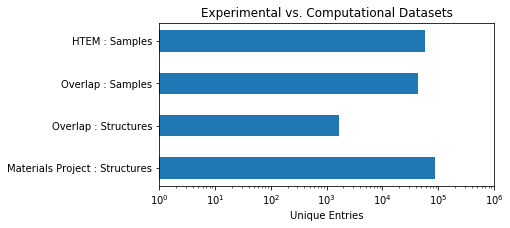

In [86]:
#make comparison chart
HTEM_samp = 57597
HTEM_sys = len(HTEM_unique_Comps)
MP_comp = 86680
Both_Uniq_sys = len(Comps_BothDB)
Both_samp = Samples_BothDB
Both_Cry = TotalStructures2Consider

Values = [MP_comp,Both_Cry,
          Both_samp,HTEM_samp]
Bins = ("Materials Project : Structures","Overlap : Structures",
        'Overlap : Samples',"HTEM : Samples")

y_pos = np.arange(len(Bins))
plt.rcParams["figure.figsize"] = (6,3)
plt.barh(y_pos, Values, align='center',height=.5)
plt.yticks(y_pos, Bins)
plt.xlabel('Unique Entries')
plt.title('Experimental vs. Computational Datasets')
plt.xscale('log')
plt.xlim((1, 1000000))
plt.show()

### The figure above shows the significant number of entries that exist in the High through-put Experimental Materials (HTEM) database and the Materials Project (MP) Database. The middle two catagories show the magnitude of overlap between the two. More than 1000 inorganic structures from MP are applicable to samples in HTEM, and more than 40,000 samples in HTEM are applicable to compounds in MP. 